# Electricity demand in Victoria 

### Megha

In [65]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from datetime import timedelta
from sklearn.metrics import mean_squared_error

# NeuralProphet
!pip install neuralprophet[live] --quiet

from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed

set_random_seed(0)
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('Dataset/Victoria_dataset.csv')
df.head()

,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y
1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N
2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N
3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N
4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N


# EDA

In [4]:
demand_df = df.copy()
demand_df = demand_df[['date','demand']].rename(columns={"date": "ds", "demand": "y"})
demand_df['ds'] = pd.to_datetime(demand_df['ds'])

In [6]:
df.isnull().sum()

date               0
demand             0
RRP                0
demand_pos_RRP     0
RRP_positive       0
demand_neg_RRP     0
RRP_negative       0
frac_at_neg_RRP    0
min_temperature    0
max_temperature    0
solar_exposure     1
rainfall           3
school_day         0
holiday            0
dtype: int64

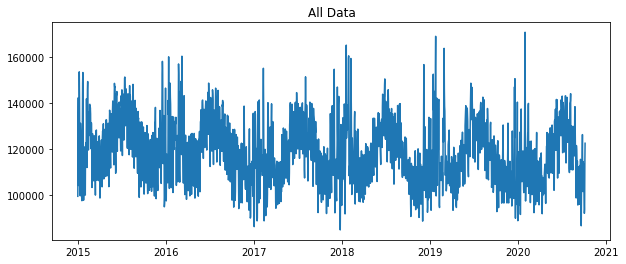

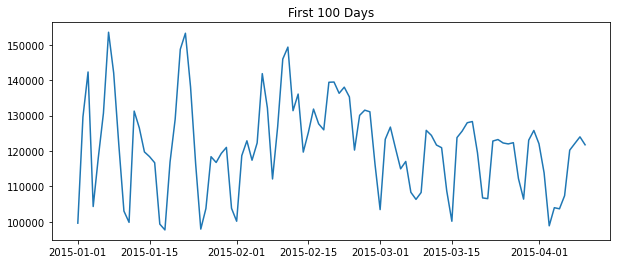

In [7]:
plt.figure(figsize=(10, 4))
plt.title("All Data")
plt.plot(demand_df['ds'].dt.to_pydatetime(), demand_df['y'])
plt.show()

plt.figure(figsize=(10, 4))
plt.title("First 100 Days")
plt.plot(demand_df['ds'].dt.to_pydatetime()[:100], demand_df['y'][:100])
plt.show()

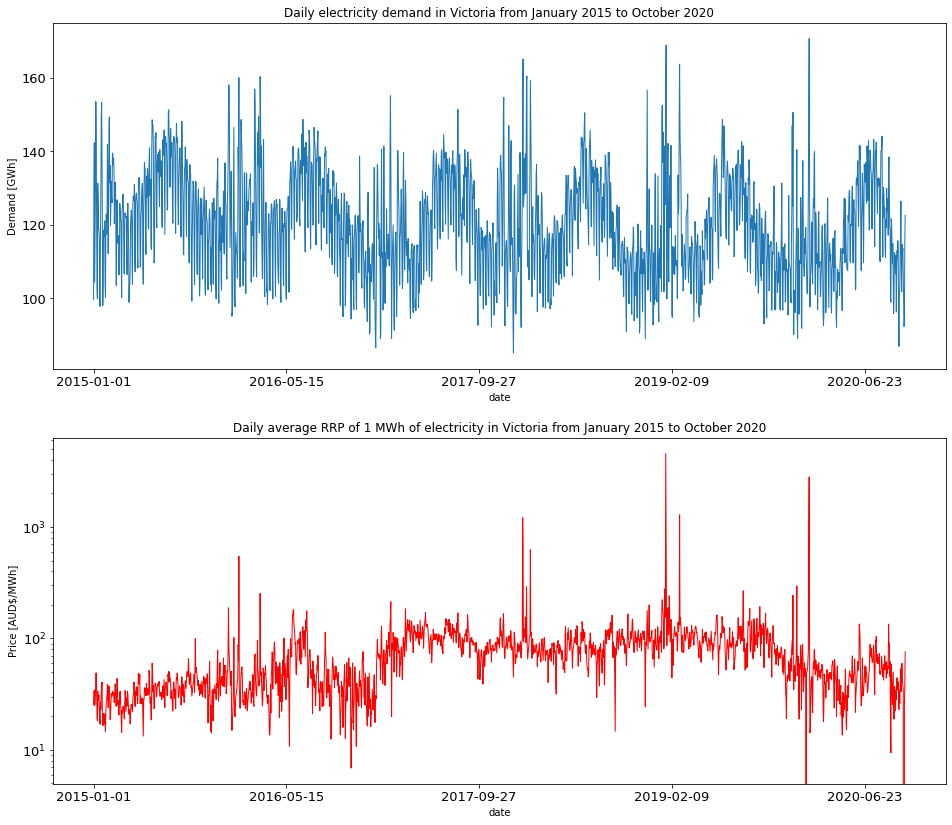

In [8]:
df_eda = df.copy()
fig, ax = plt.subplots(2, 1, figsize = (16, 14))
ax[0].tick_params(axis='both', which='major', labelsize=13)
ax[1].tick_params(axis='both', which='major', labelsize=13)

df_eda['demand'] = df_eda['demand'] / 1000
df_eda.plot(x='date', y='demand', lw = 1, ax = ax[0])
df_eda['demand'] = df_eda['demand'] * 1000
ax[0].set_title("Daily electricity demand in Victoria from January 2015 to October 2020")
ax[0].set_ylabel("Demand [GWh]")
ax[0].get_legend().remove()

df_eda.plot(x='date', y='RRP', lw = 1, color='red', ax = ax[1])
ax[1].set_title("Daily average RRP of 1 MWh of electricity in Victoria from January 2015 to October 2020")
ax[1].set_ylabel("Price [AUD$/MWh]")
ax[1].get_legend().remove()
plt.yscale("log")

(0.0, 0.65)

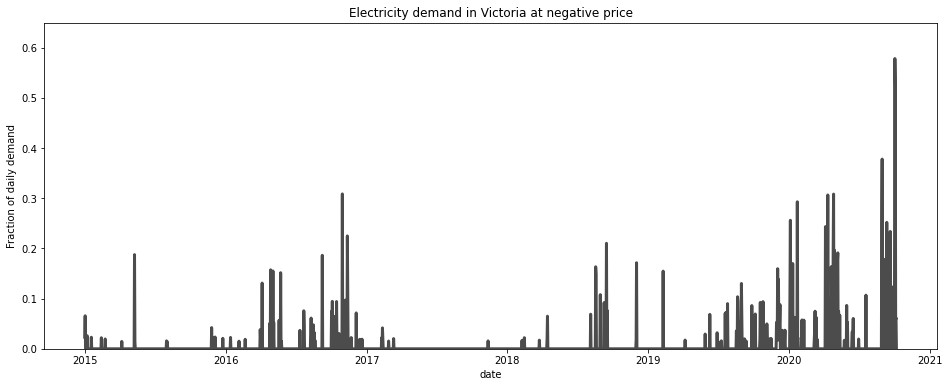

In [9]:
# Frequency and a relative magnitude (to a total demand on that day) of demand at negative prices.
plt.figure(figsize=(16, 6))
plt.plot(pd.to_datetime(df_eda['date']), df_eda['demand_neg_RRP']/df_eda['demand'], lw=3, color='black', alpha=0.7)
plt.xlabel('date')
plt.ylabel('Fraction of daily demand')
plt.title("Electricity demand in Victoria at negative price")
plt.ylim([0, 0.65])

<AxesSubplot:xlabel='max_temperature (norm)', ylabel='Density'>

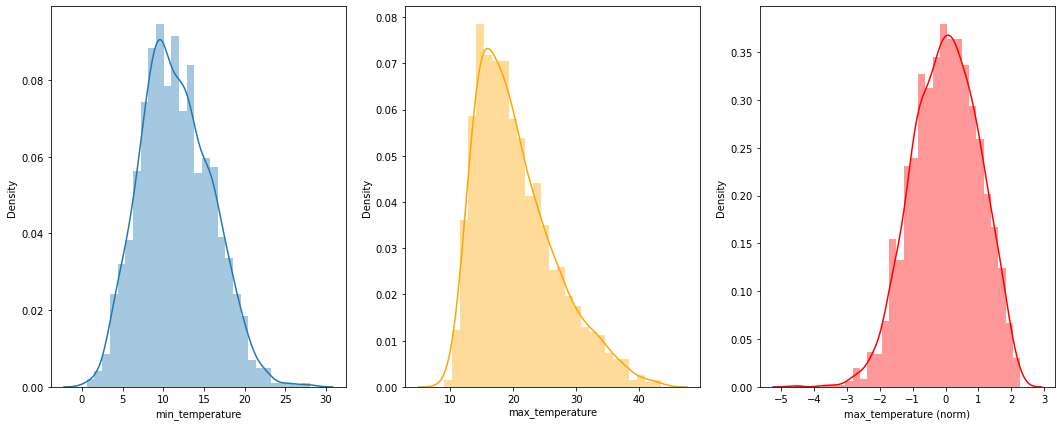

In [10]:
# Maximum and minimum daily temperatures have a skewed distribution. Some model better deal with normalised data.
# Last plot on the right depicts normalised (mean = 0, std = 1) temperature.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 7))

def shift_log(df_eda, col_name):
    """
    Transform by shift so that min element = 1 and taking log
    """
    vals = df_eda[col_name].values
    shift = np.min(vals)
    vals = np.log(vals - shift + 1)
    df_eda[col_name + " (norm)"] = (vals - vals.mean())/vals.std()

shift_log(df_eda, 'max_temperature')
    
sns.distplot(df_eda['min_temperature'], ax=ax1)
sns.distplot(df_eda['max_temperature'], color='orange', ax=ax2)
sns.distplot(df_eda['max_temperature (norm)'], color='red', ax=ax3)

<AxesSubplot:title={'center':'Temperature'}, xlabel='date'>

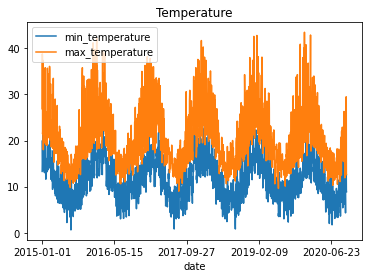

In [11]:
pd.options.plotting.backend = "matplotlib" 
df_eda.plot(x='date', y=['min_temperature', 'max_temperature'], title='Temperature')

<AxesSubplot:title={'center':'Daily rainfall, mm'}, xlabel='date'>

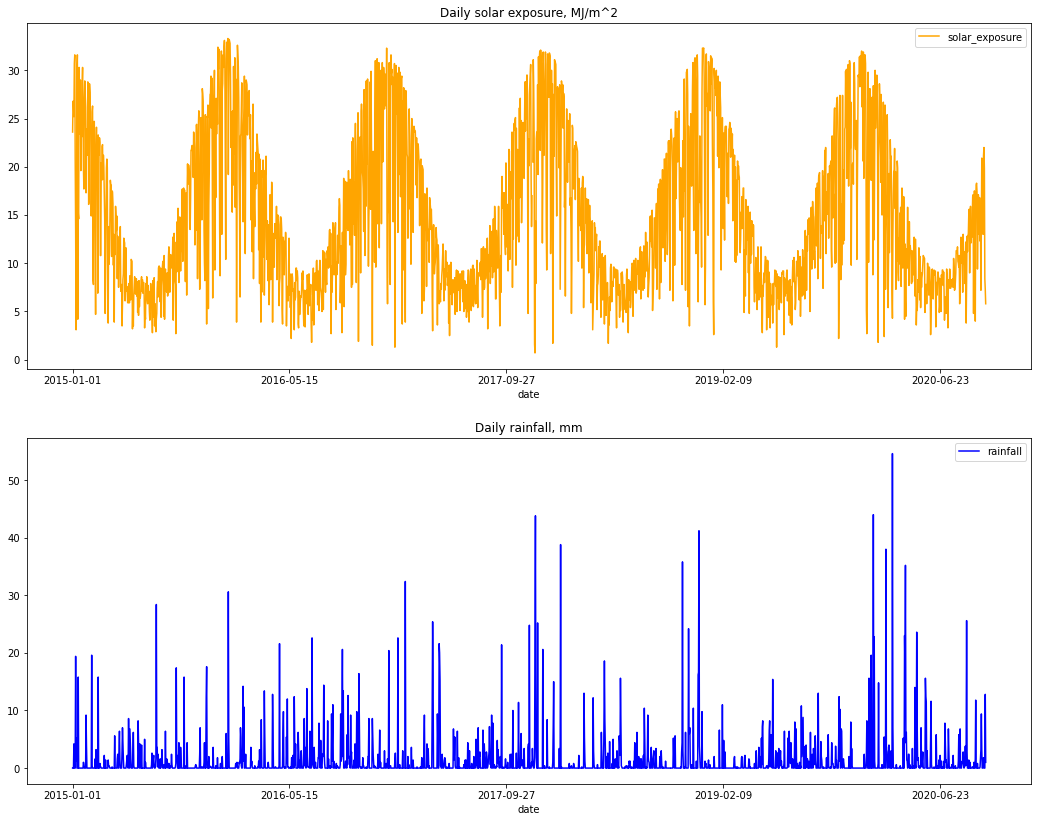

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(18, 14))

df_eda.plot(x='date', y='solar_exposure', ax=ax[0], color='orange', title = "Daily solar exposure, MJ/m^2")
df_eda.plot(x='date', y='rainfall', color='blue', ax=ax[1], title = "Daily rainfall, mm")

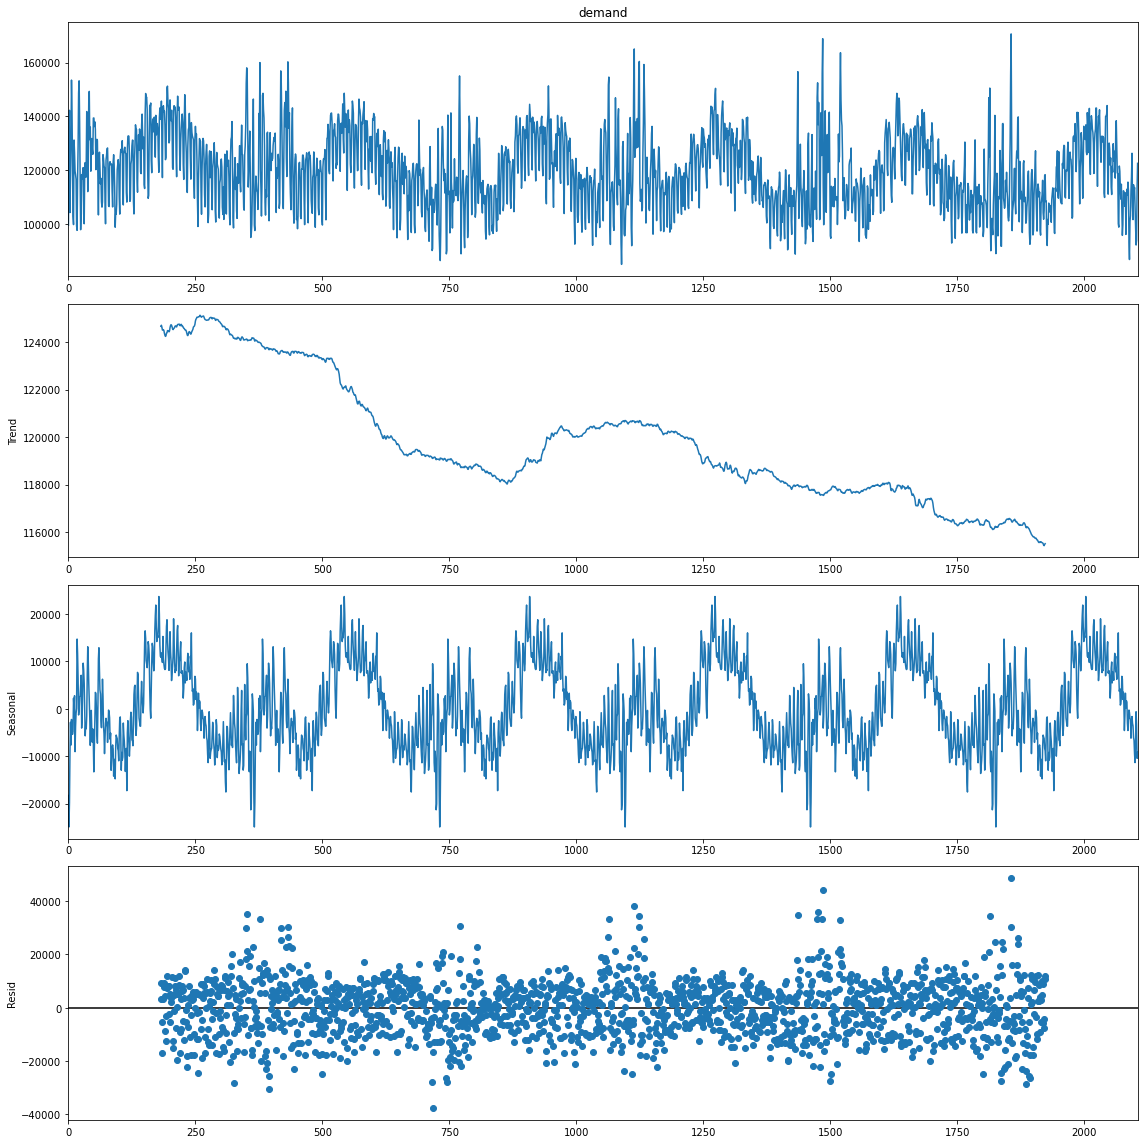

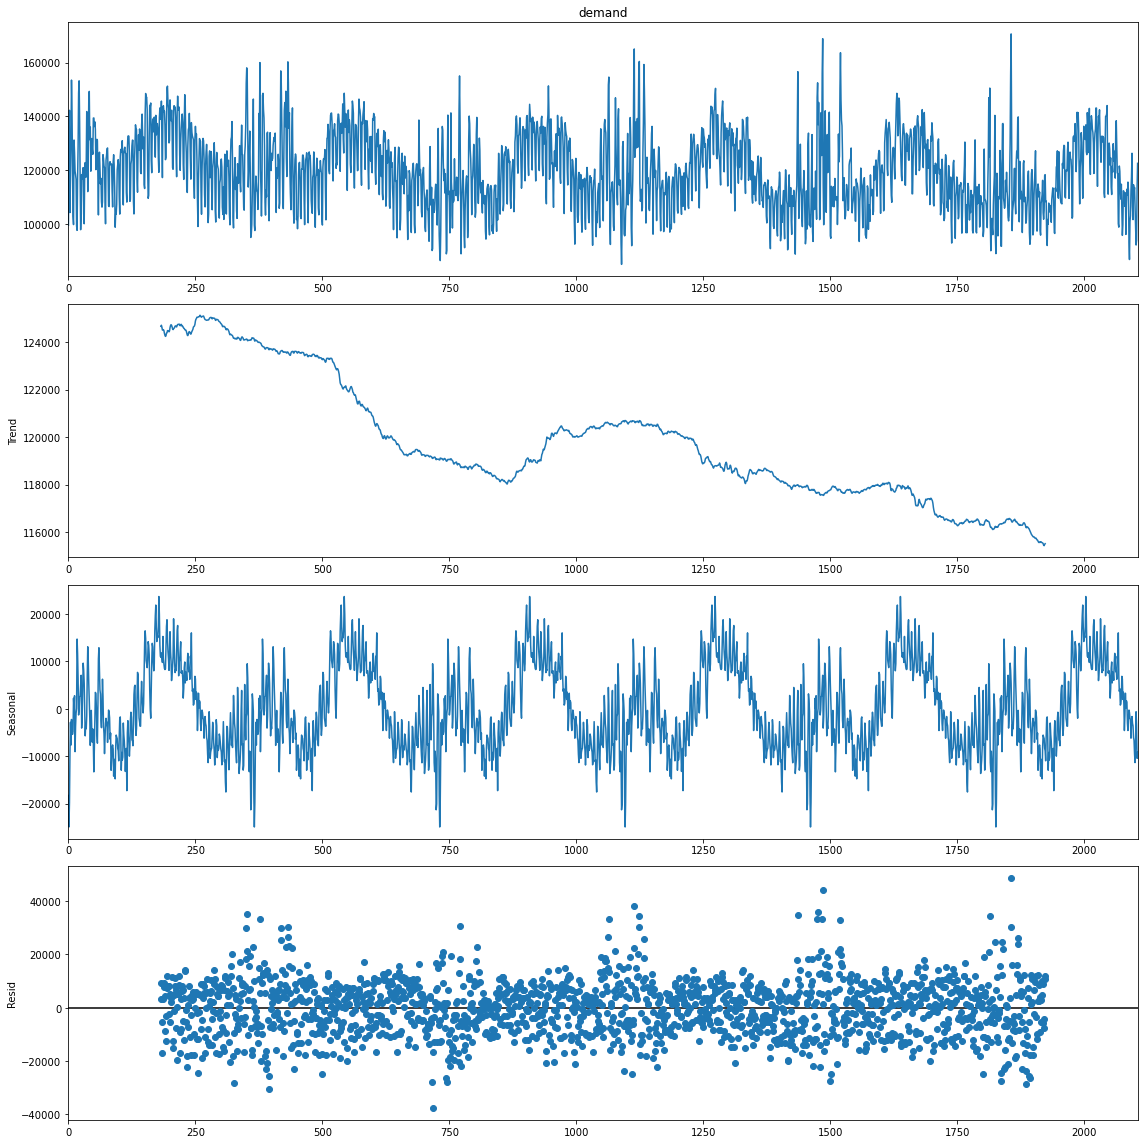

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams["figure.figsize"] = (16, 16)

T = 365 # days in a year
decompose = seasonal_decompose(x=df_eda['demand'], period=T, model='additive')
decompose.plot()

<AxesSubplot:>

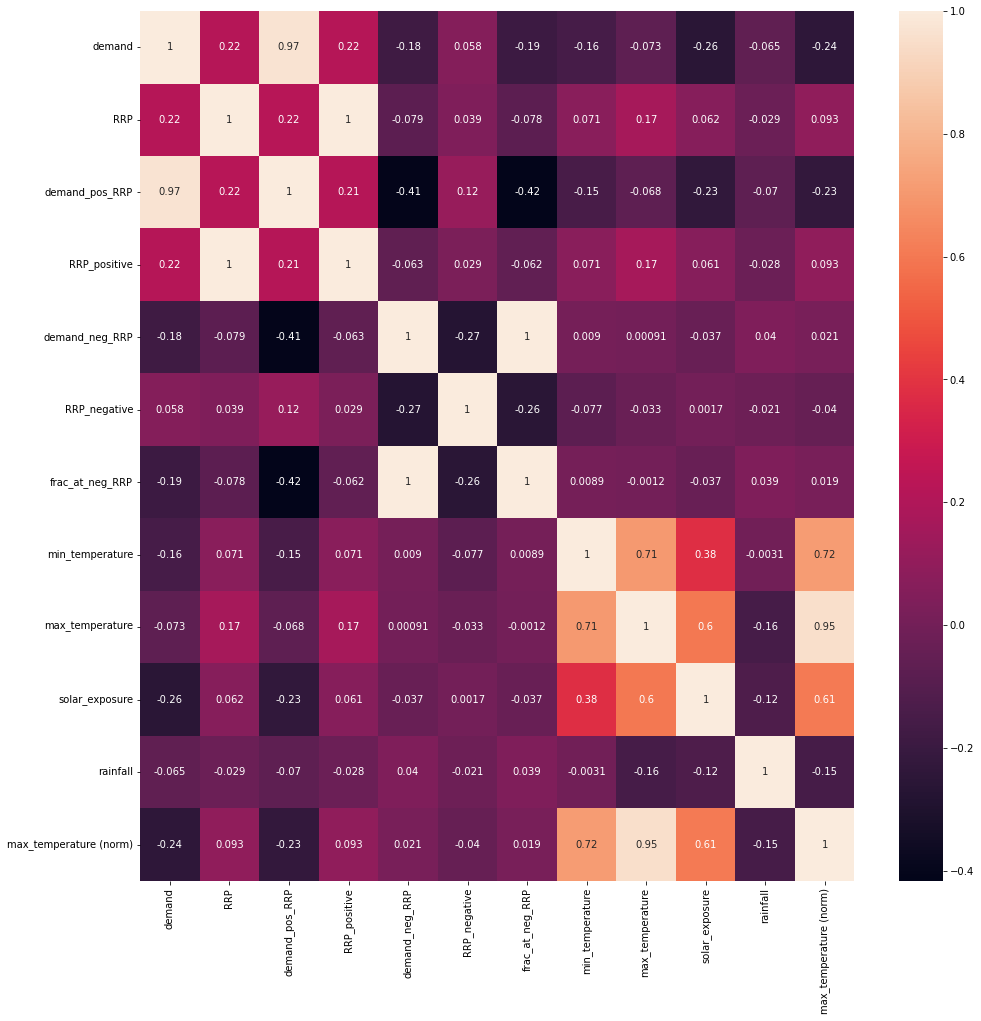

In [14]:
corr = df_eda[[col for col in df_eda.columns if df_eda[col].dtypes == np.float64]].corr()
sns.heatmap(corr, annot=True)

# Prophet

In [15]:
df_pr = df.copy()
df_pr = df.reset_index()
df_pr = df_pr[['date','demand']].rename(columns={"date": "ds", "demand": "y"})
df_pr['ds'] = pd.to_datetime(df_pr['ds'])

df_pr.head()

,ds,y
0,2015-01-01,99635.030
1,2015-01-02,129606.010
2,2015-01-03,142300.540
3,2015-01-04,104330.715
4,2015-01-05,118132.200


In [16]:
m = NeuralProphet()

In [17]:
train_data_pr, test_data_pr  = df_pr[:int(len(df_pr)*0.8)], df_pr[int(len(df_pr)*0.8):]

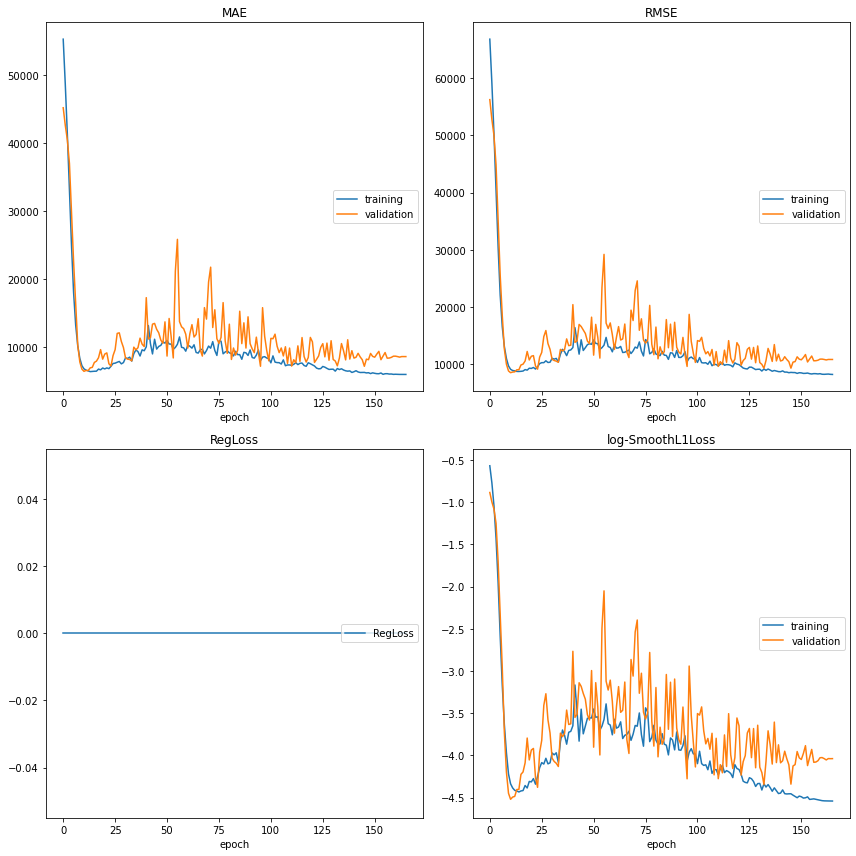

MAE
	training         	 (min: 5932.052, max: 55354.412, cur: 5932.052)
	validation       	 (min: 6389.931, max: 45243.887, cur: 8562.677)
RMSE
	training         	 (min: 8184.474, max: 66821.673, cur: 8184.474)
	validation       	 (min: 8488.816, max: 56245.781, cur: 10801.181)
RegLoss
	RegLoss          	 (min:    0.000, max:    0.000, cur:    0.000)
log-SmoothL1Loss
	training         	 (min:   -4.541, max:   -0.569, cur:   -4.541)
	validation       	 (min:   -4.520, max:   -0.886, cur:   -4.038)


,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
165,0.010664,5932.051677,8184.473765,0.0,0.017624,8562.676758,10801.180664


In [18]:
m.add_country_holidays(country_name='Australia')
metrics = m.fit(df=train_data_pr,validation_df=test_data_pr, freq="D", progress="plot-all")
metrics[-1:]

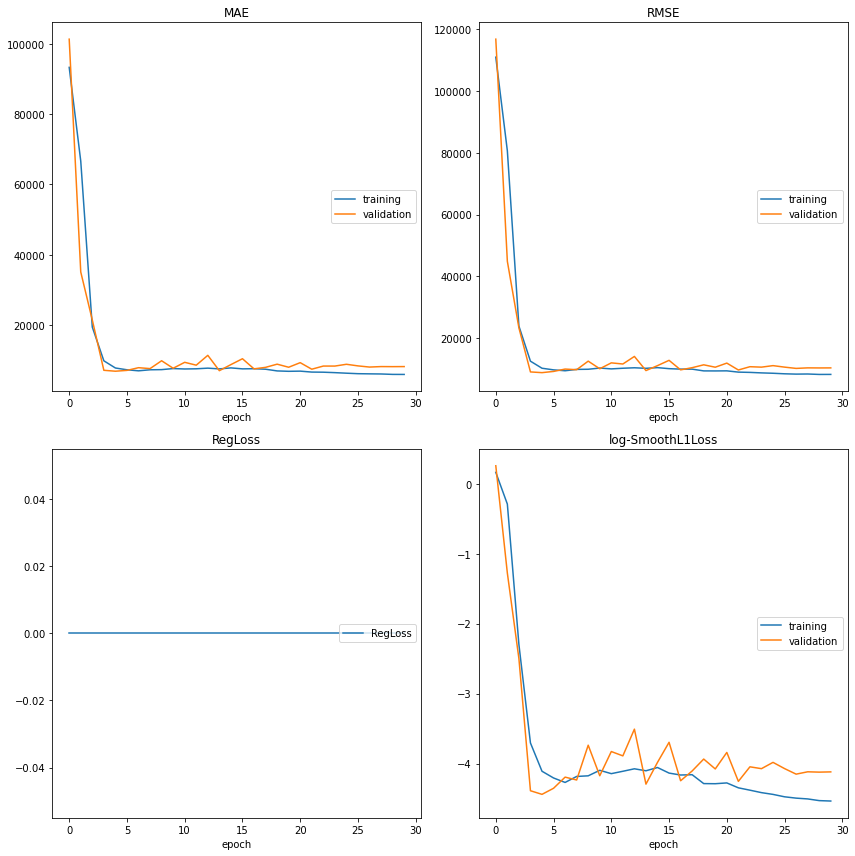

MAE
	training         	 (min: 5944.798, max: 93330.923, cur: 5944.798)
	validation       	 (min: 6862.363, max: 101353.906, cur: 8179.492)
RMSE
	training         	 (min: 8251.233, max: 110916.573, cur: 8260.189)
	validation       	 (min: 8831.038, max: 116747.438, cur: 10369.920)
RegLoss
	RegLoss          	 (min:    0.000, max:    0.000, cur:    0.000)
log-SmoothL1Loss
	training         	 (min:   -4.537, max:    0.165, cur:   -4.537)
	validation       	 (min:   -4.441, max:    0.259, cur:   -4.120)


,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
29,0.010706,5944.797703,8260.189138,0.0,0.016245,8179.491699,10369.919922


In [19]:
m = NeuralProphet(epochs=30)
m.add_country_holidays(country_name='Australia')
metrics2 = m.fit(df=train_data_pr, validation_df=test_data_pr, freq="D",progress="plot-all")
metrics2[-1:]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.941% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.953% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.953% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


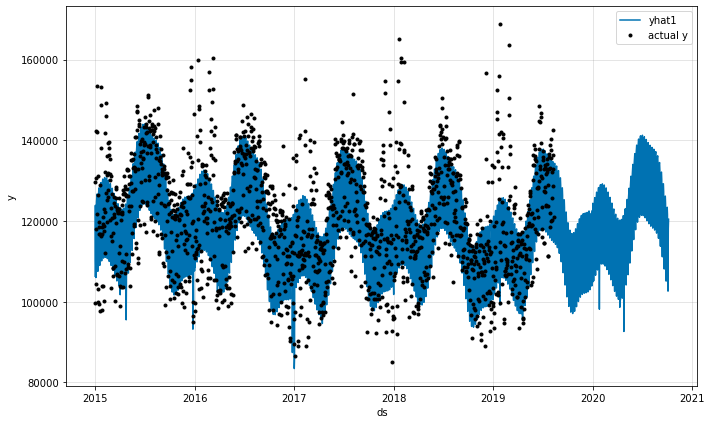

In [20]:
future_pr = m.make_future_dataframe(df=train_data_pr, periods=len(test_data_pr), n_historic_predictions=True)
forecast = m.predict(df=future_pr)
fig_forecast = m.plot(forecast)

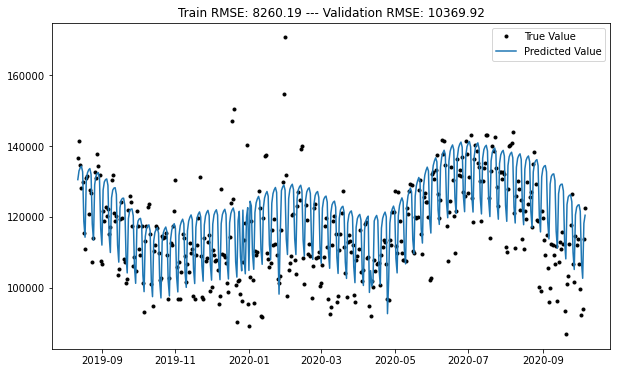

In [21]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_title("Train RMSE: {:.2f} --- Validation RMSE: {:.2f}".format(metrics2[-1:].RMSE.values[0], metrics2[-1:].RMSE_val.values[0]))
ax.plot(test_data_pr['ds'].dt.to_pydatetime(), test_data_pr["y"],'.k', label='True Value')
ax.plot(forecast[-len(test_data_pr):]['ds'].dt.to_pydatetime(), forecast[-len(test_data_pr):]["yhat1"], label='Predicted Value')
ax.legend()
plt.show()

In [22]:
m = NeuralProphet(n_forecasts=1, n_lags=3, epochs=30, changepoints_range=0.95)
m.add_country_holidays(country_name='Australia')
metrics3 = m.fit(df=train_data_pr, validation_df=test_data_pr, freq="D")
metrics3[-1:]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.941% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32


  0%|          | 0/131 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.70E-01, min: 3.00E+00


  0%|          | 0/131 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.70E-01, min: 7.14E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.43E-01
Epoch[30/30]: 100%|█| 30/30 [00:05<00:00,  5.71it/s, SmoothL1Loss=0.00616, MAE=4.47e+3, RMSE=6.26e+3, RegLoss=0, MAE_va


,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
29,0.006158,4466.269524,6257.102904,0.0,0.008728,5716.432129,7600.82959


In [23]:
valid_preds = [] #list to store predictions
lags = 3

for d in test_data_pr['ds'].values:
    # getting necessary df rows
    date_index = df_pr.index[df_pr['ds'] == d][0]
    future = df_pr.iloc[date_index-lags:date_index]
    
    # adding new row
    entry = pd.DataFrame({
        'ds': [d],
        'y' : [np.nan]
    })
    future = pd.concat([future, entry], ignore_index = True, axis = 0)
    
    # making prediction
    forecast = m.predict(df=future)
    valid_preds.append(forecast.loc[lags]['yhat1'])

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data

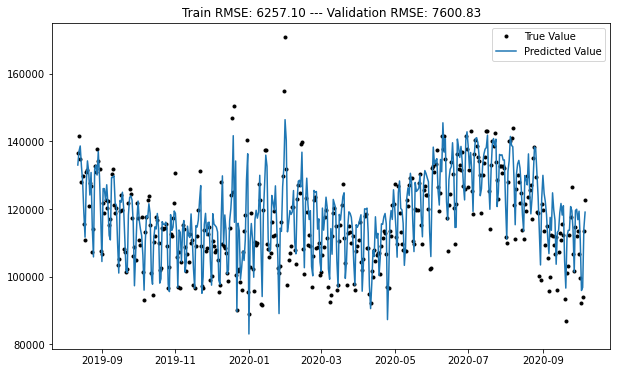

In [24]:
# Creating DF for predictions
df_valid_copy = test_data_pr.copy()
df_valid_copy['yhat1'] = valid_preds
df_valid_copy.head()

# Plotting Predictions
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_title("Train RMSE: {:.2f} --- Validation RMSE: {:.2f}".format(metrics3[-1:].RMSE.values[0], metrics3[-1:].RMSE_val.values[0]))
ax.plot(df_valid_copy['ds'].dt.to_pydatetime(), df_valid_copy["y"],'.k', label='True Value')
ax.plot(df_valid_copy['ds'].dt.to_pydatetime(), df_valid_copy["yhat1"], label='Predicted Value')
ax.legend()
plt.show()

In [25]:
import itertools
# Parameter Options
param_grid = {  
    'num_hidden_layers': [1,2],
    'changepoints_range': [0.95, 0.975, 0.99, 0.995, 0.999],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
results = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = NeuralProphet(**params, n_forecasts=1, newer_samples_weight=4, n_lags=3, learning_rate=0.02, epochs=50, batch_size=32)
    m.add_country_holidays(country_name='Australia')
    metrics4 = m.fit(df=train_data_pr, validation_df=test_data_pr, freq="D")
    results.append(dict({"RMSE_val": metrics4['RMSE_val'].min(), "RMSE_train": metrics4['RMSE'][metrics4['RMSE_val'].idxmin()], "score_epoch_number": metrics4['RMSE_val'].idxmin()}, **params))

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.941% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
Epoch[50/50]: 100%|█| 50/50 [00:07<00:00,  6.59it/s, SmoothL1Loss=0.00627, MAE=4.53e+3, RMSE=6.31e+3, RegLoss=0, MAE_va
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.941% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
Epoch[50/5

In [26]:
# Find the best parameters
results_df = pd.DataFrame.from_dict(results, orient='columns')
results_df = results_df.sort_values('RMSE_val')
results_df.head(10)

,RMSE_val,RMSE_train,score_epoch_number,num_hidden_layers,changepoints_range
4,6901.395996,7235.293339,9,1,0.999
2,6912.591797,6832.073986,25,1,0.990
0,6959.727051,6567.743238,31,1,0.950
8,6983.280273,6362.855859,41,2,0.995
6,7026.378418,6543.299199,38,2,0.975
5,7293.916016,6883.730708,38,2,0.950
9,7479.510742,7121.168027,36,2,0.999
7,7710.133301,6411.041078,39,2,0.990
3,7760.925293,6491.643986,33,1,0.995
1,7871.949707,6528.558398,42,1,0.975


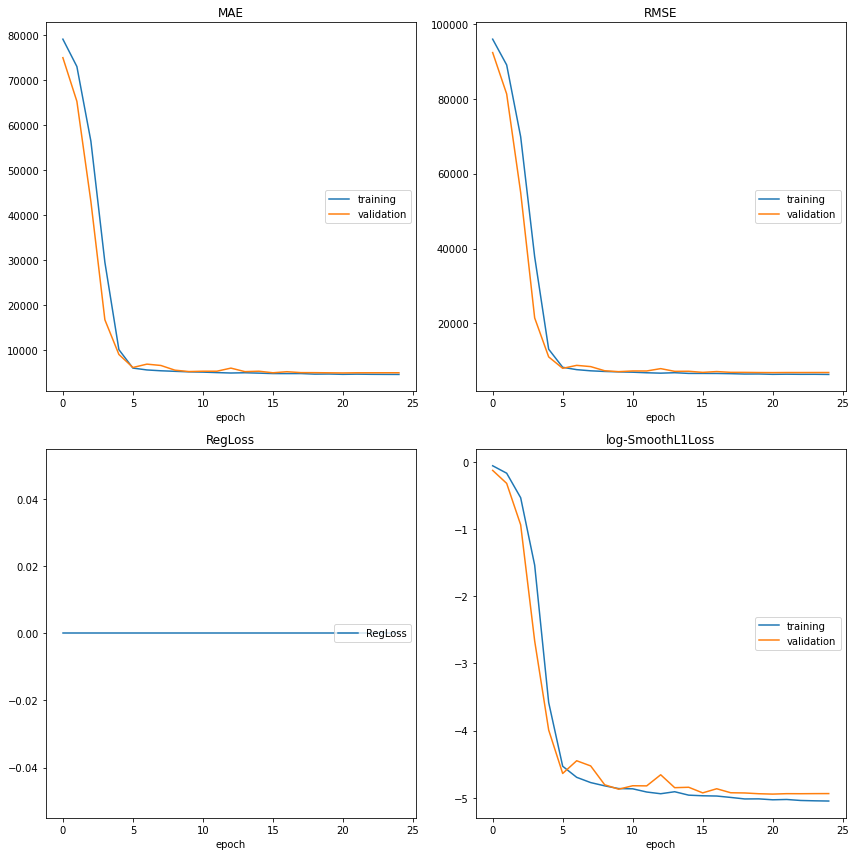

MAE
	training         	 (min: 4592.401, max: 79041.662, cur: 4592.401)
	validation       	 (min: 4923.419, max: 74928.594, cur: 4966.514)
RMSE
	training         	 (min: 6374.459, max: 95897.095, cur: 6374.459)
	validation       	 (min: 6863.926, max: 92318.414, cur: 6890.568)
RegLoss
	RegLoss          	 (min:    0.000, max:    0.000, cur:    0.000)
log-SmoothL1Loss
	training         	 (min:   -5.048, max:   -0.059, cur:   -5.048)
	validation       	 (min:   -4.945, max:   -0.127, cur:   -4.937)


,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
24,0.00642,4592.401139,6374.458913,0.0,0.007173,4966.513672,6890.567871


In [31]:
m = NeuralProphet(newer_samples_weight=5, n_forecasts=1, n_lags=3, learning_rate=0.02, epochs=25, batch_size=32, num_hidden_layers=1, changepoints_range=0.950)
m.add_country_holidays(country_name='Australia')
metrics5 = m.fit(df=train_data_pr, validation_df=test_data_pr, freq="D", progress="plot-all")
metrics5[-1:]

In [32]:
valid_preds = [] #list to store predictions
lags = 3

for d in test_data_pr['ds'].values:
    # getting necessary df rows
    date_index = df_pr.index[df_pr['ds'] == d][0]
    future = df_pr.iloc[date_index-lags:date_index]
    
    # adding new row
    entry = pd.DataFrame({
        'ds': [d],
        'y' : [np.nan]
    })
    future = pd.concat([future, entry], ignore_index = True, axis = 0)
    
    # making prediction
    forecast = m.predict(df=future)
    valid_preds.append(forecast.loc[lags]['yhat1'])

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data

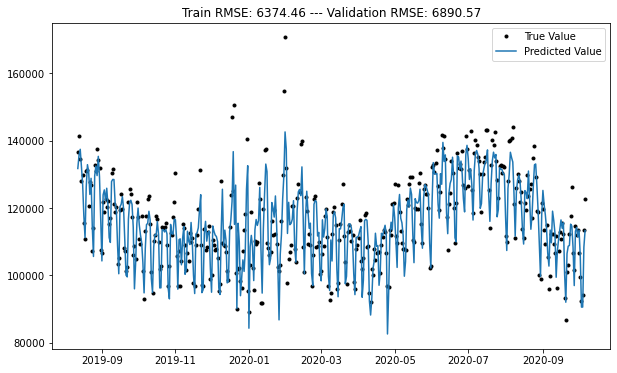

In [33]:
# Creating DF for predictions
df_valid_copy = test_data_pr.copy()
df_valid_copy['yhat1'] = valid_preds
df_valid_copy.head()

# Plotting Predictions
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_title("Train RMSE: {:.2f} --- Validation RMSE: {:.2f}".format(metrics5[-1:].RMSE.values[0], metrics5[-1:].RMSE_val.values[0]))
ax.plot(df_valid_copy['ds'].dt.to_pydatetime(), df_valid_copy["y"],'.k', label='True Value')
ax.plot(df_valid_copy['ds'].dt.to_pydatetime(), df_valid_copy["yhat1"], label='Predicted Value')
ax.legend()
plt.show()

In [34]:
import math
y = mean_squared_error(df_valid_copy["y"], df_valid_copy["yhat1"])
rmse = math.sqrt(y)  
rmse

6877.407192205196

In [35]:
perc = (abs(sum(df_valid_copy["yhat1"]) - sum(df_valid_copy["y"])) / (sum(df_valid_copy["y"])))*100
perc

0.2552970640722775

# SARIMA

In [44]:
df_arima = df.copy()

In [45]:
df_arima = df_arima[['date','demand']].rename(columns={"date": "ds", "demand": "y"})
df_arima['ds'] = pd.to_datetime(df_arima['ds'])
df_arima = df_arima.set_index("ds")
df_arima

,ds,y
0,2015-01-01,99635.030
1,2015-01-02,129606.010
2,2015-01-03,142300.540
3,2015-01-04,104330.715
4,2015-01-05,118132.200
...,...,...
2101,2020-10-02,99585.835
2102,2020-10-03,92277.025
2103,2020-10-04,94081.565
2104,2020-10-05,113610.030


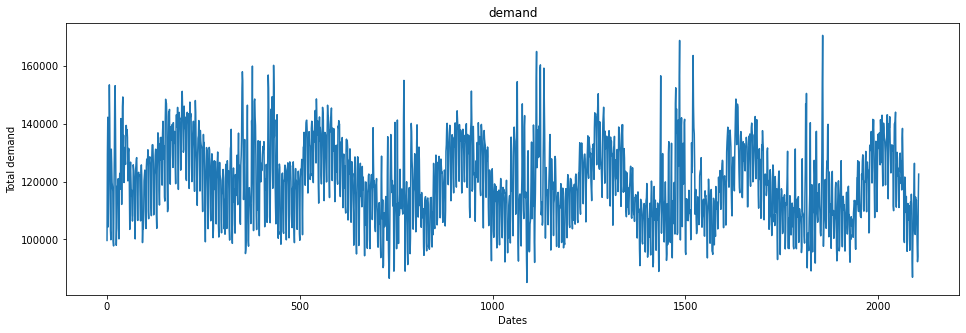

In [46]:
df_arima.index.freq = 'D'
ax = df_arima['y'].plot(figsize = (16,5), title = "demand")
ax.set(xlabel='Dates', ylabel='Total demand');

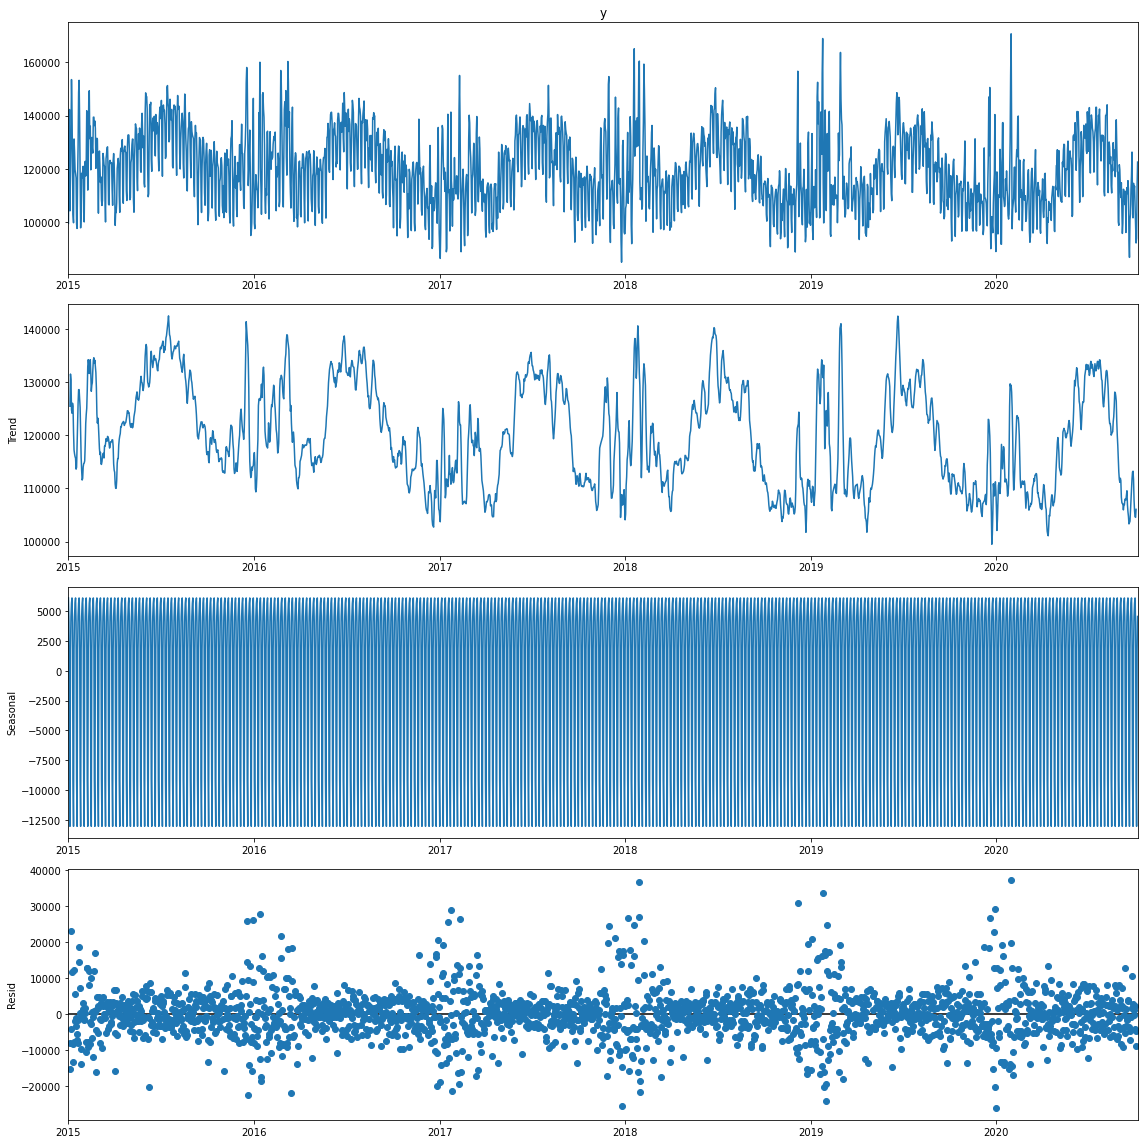

In [39]:
a = seasonal_decompose(df_arima["y"], model = "add")
a.plot();

In [47]:
train_data_ar, test_data_ar = df_arima[:int(len(df_arima)*0.8)], df_arima[int(len(df_arima)*0.8):]

In [48]:
import pmdarima as pm

# Seasonal - Find best parameters with Auto-ARIMA
SARIMA_model = pm.auto_arima(train_data_ar['y'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=7, #weekly frequency
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

SARIMA_model

ARIMA(order=(1, 0, 1), scoring_args={}, seasonal_order=(0, 1, 1, 7),
      suppress_warnings=True)

In [49]:
%%time
# SARIMA Method
from statsmodels.tsa.arima.model import ARIMA

sarima_preds = []

for d in test_data_ar['ds'].values:
    # Setting up dataframe
    date_index = df_arima.index[df_arima['ds'] == d][0]
    future = df_arima.iloc[date_index-len(train_data_ar):date_index]
    future = future.set_index('ds')
    future.index = pd.DatetimeIndex(future.index.values, freq='D')
    
    # Fit model + make predictions
    m_sarima = ARIMA(future['y'], order=(1,0,1), seasonal_order=(0, 1, 1, 7)).fit()
    sarima_preds.append(m_sarima.forecast(1).values[0])
    
sarima_rmse = mean_squared_error(test_data_ar['y'], sarima_preds, squared=False)
sarima_rmse

CPU times: total: 13min 48s
Wall time: 9min 8s


7467.200212489472

In [50]:
import math
y = mean_squared_error(test_data_ar['y'], sarima_preds)
rmse = math.sqrt(y)  
rmse

7467.200212489472

In [51]:
perc = (abs(sum(sarima_preds) - sum(test_data_ar['y'])) / (sum(test_data_ar['y'])))*100
perc

0.5115172987611897

# LSTM

In [52]:
df_lstm = df.copy()

In [53]:
df_lstm = df_lstm[['date','demand']].rename(columns={"date": "ds", "demand": "y"})
df_lstm['ds'] = pd.to_datetime(df_lstm['ds'])
df_lstm = df_lstm.set_index("ds")
df_lstm.index.freq = 'D'
train_data_lstm, test_data_lstm = df_lstm[:int(len(df_lstm)*0.8)], df_lstm[int(len(df_lstm)*0.8):]


In [54]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data_lstm)
scaled_train_data = scaler.transform(train_data_lstm)
scaled_test_data = scaler.transform(test_data_lstm)

In [55]:
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Dropout
n_input = scaled_train_data.shape[0] -1 
n_features= scaled_train_data.shape[1]
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()

model.add(LSTM(units =128, activation='relu', return_sequences=True, input_shape = (n_input, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(units =128, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units =128, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 12, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 12, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 12, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [56]:
model.fit_generator(generator,epochs=20)

Epoch 1/20
2082/2082 [==============================] - 30s 11ms/step - loss: 0.0259
Epoch 2/20
2082/2082 [==============================] - 23s 11ms/step - loss: 0.0213
Epoch 3/20
2082/2082 [==============================] - 24s 11ms/step - loss: 0.0212
Epoch 4/20
2082/2082 [==============================] - 29s 14ms/step - loss: 0.0208
Epoch 5/20
2082/2082 [==============================] - 26s 12ms/step - loss: 0.0198
Epoch 6/20
2082/2082 [==============================] - 25s 12ms/step - loss: 0.0190
Epoch 7/20
2082/2082 [==============================] - 27s 13ms/step - loss: 0.0167
Epoch 8/20
2082/2082 [==============================] - 32s 15ms/step - loss: 0.0157
Epoch 9/20
2082/2082 [==============================] - 28s 13ms/step - loss: 0.0147
Epoch 10/20
2082/2082 [==============================] - 29s 14ms/step - loss: 0.0144
Epoch 11/20
2082/2082 [==============================] - 26s 12ms/step - loss: 0.0134
Epoch 12/20
2082/2082 [==============================] - 26s 13

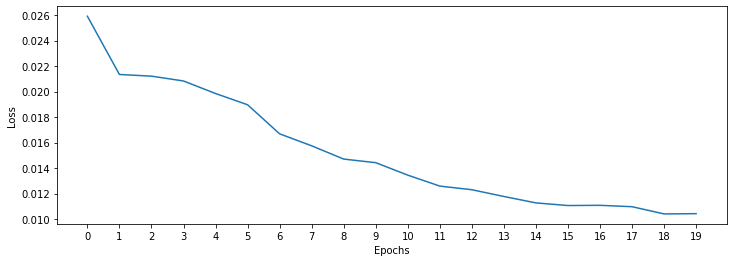

In [57]:
losses_lstm = model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [58]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(scaled_test_data)):   
    lstm_pred = model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

1/1 [==============================] - 0s 24ms/step


In [59]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
lstm_predictions

array([[112662.57299992],
       [104012.21039542],
       [ 97170.34362692],
       [105807.35638306],
       [114045.59740103],
       [115462.50958453],
       [114528.2573373 ],
       [108818.60968203],
       [102642.1406127 ],
       [ 98920.28933054],
       [107023.66895899],
       [114409.3568638 ]])

In [60]:
lstm_rmse_error = mean_squared_error(test_data_lstm['y'], lstm_predictions, squared=False)
lstm_rmse_error

7580.592091895904

In [61]:
perc = (abs(sum(lstm_predictions) - sum(test_data_lstm['y'])) / (sum(test_data_lstm['y'])))*100
perc[0]

0.6443597067784343

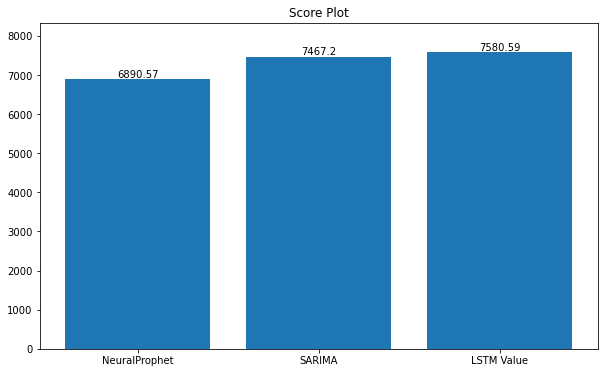

In [64]:
def score_plot():
    """Visualizing the training + validation sets"""
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    
    scores = {
        "NeuralProphet": metrics5[-1:].RMSE_val.values[0],
        "SARIMA": sarima_rmse,
        "LSTM Value": lstm_rmse_error,
    }
    
    ax.set_title("Score Plot")
    ax.bar(scores.keys(), scores.values())
    ax.bar_label(ax.containers[0], label_type='edge')
    ax.margins(y=0.1)
    plt.show()

score_plot()